In [1]:
# Check along-fjord properties in wind-forcing runs
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import cmocean
import Functions as fun
import os, sys
#sys.path.append(os.path.abspath('/work/oceans/wbao/MITgcm_results/jorgemontt'))

In [2]:
# Input file info
#path1 = '/work/oceans/wbao/MITgcm_results/jorgemontt/Qsg150_wind'
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind/'
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_rep_wind/'
path3 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind_notide/'
path4 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind1_nBathy/'
path5 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind1_nSill/'
path6 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_S/'
path7 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_NS/'

taum1 = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5]) # maximum wind stress (single event)
taum2 = np.array([-0.2, -0.1, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8]) # maximum wind stress (repeated events)
taum3 = np.array([0,0.1,0.3,0.8,1.5])
taum4 = np.array([0, 0.1, 0.3, 0.9, 1.5, -0.1, -0.3, -0.9, -1.5])
taum5 = taum4
taum6 = np.array([0, 0.1, 0.3, -0.1, -0.3])
taum7 = taum6

xrange = np.array([0,97]) # X index range for the segment between glacier and outer sill
xsill = 95

## Wind Forcing

In [ ]:
# Zonal Wind Stress
externForcingCircle = 30*86400 # Forcing period in second
externForcingPeriod = 0.25*86400 # time interval between forcing field records
nt = int(externForcingCircle / externForcingPeriod)
model_time = np.linspace(0,externForcingCircle,nt+1);
up = 0*86400 / externForcingPeriod
down = 2.5*86400 / externForcingPeriod
ramp = 0.5*86400 / externForcingPeriod
taum = taum3.copy() # maximum wind stress

zonal_wind_stress = np.zeros((len(taum),nt))

nf = int(down+ramp)
forcing = np.zeros((len(taum),nf))

for i in range(0,len(taum)):
    tau = taum[i]
    for j in range(nf):
        if j <= up - 1:
            forcing[i, j] = 0
        elif j < up + ramp - 1:
            forcing[i, j] = tau * (j - (up - 1)) / ramp
        elif j > down-1:
            forcing[i, j] = tau * (down + ramp - 1 - j) / ramp
        else:
            forcing[i, j] = tau

zonal_wind_stress[:,:nf] = forcing

rt = 1 # number of repeated wind events

zonal_wind_stress[:,:nf*rt] = np.tile(forcing, rt)

wind = np.concatenate((np.zeros((len(taum),1)), zonal_wind_stress), axis=1)

## Along-Fjord Properties
* `dist`: along-fjord distance [km]
* `depth`: meters
* `time`: seconds
* `temp`: potential temperature
* `sal`: salinity
* `den`: density
* `u`: along-fjord velocity
* `w`: vertical velocity

In [5]:
# No-wind case
#dist, depth, time, temp0, sal0, den0, u0, w0 = fun.along_fjord_state(path1,3)
dist, depth, time, temp0, sal0, den0, u0, w0 = fun.along_fjord_state(path7,1)

In [ ]:
# Single wind event
# tau_max = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5])
caseN = 1
print("Maximum zonal wind stress: {} N/m^2".format(taum6[caseN-1]))
dist, depth, time, temp, sal, den, u, w = fun.along_fjord_state(path6,caseN)
diagT, qsm_a, qsm_z = fun.Qsm(path6,caseN)

## Time-mean along-fjord

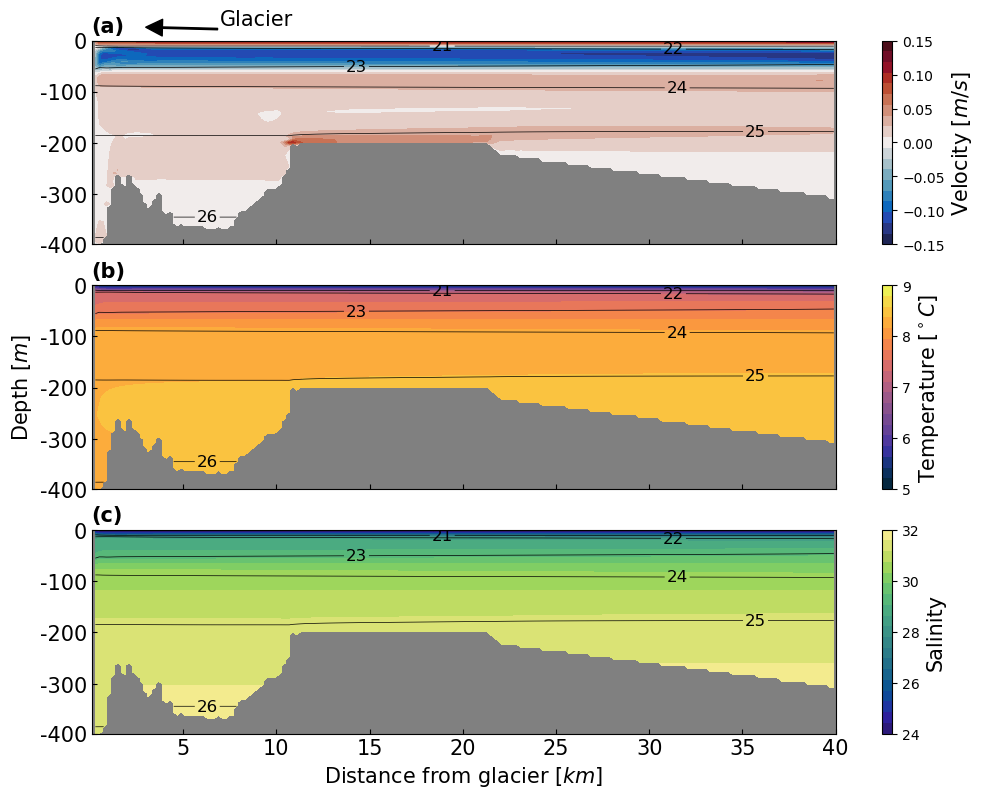

In [6]:

# Plot along-fjord velocity, temperature, and salinity
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,9))



# Time-mean (60~90d)
U, Temp, Sal, RhoA = -1*u0.mean(0), temp0.mean(0), sal0.mean(0), den0.mean(0)-1000
pt0 = temp0[0,:,:]
mask = (pt0 == 0)
U[mask] = np.nan
Temp[mask] = np.nan
Sal[mask] = np.nan
RhoA[mask] = np.nan

cr_u = np.linspace(-0.15,0.15,20) # Contour range
cr_t = np.linspace(5,9,20)
cr_s = np.linspace(24,32,20)
cr_rho = np.linspace(21,27,7)

# Along-fjord velocity
im1 = ax1.contourf(dist, depth, U, cr_u, cmap=cmocean.cm.balance)
# Add cross-sections
# ax1.axvline(x=dist[3], color='b',lw=2)
# ax1.axvline(x=dist[60], color='b',lw=2)
# ax1.axvline(x=dist[70], color='b',lw=2)
# ax1.axvline(x=dist[90], color='b',lw=2)
# ax1.axvline(x=dist[100], color='b',lw=2)
#ax1.axhline(y=-50, color='b',lw=2)
CS1 = ax1.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig1.colorbar(im1,ax=ax1)
#cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_ticks([-0.15, -0.1,-0.05,0,0.05,0.1,0.15])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=15, weight='bold')

ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15, annotation_clip=False)


# Potential temperature
im2 = ax2.contourf(dist, depth, Temp, cr_t, cmap=cmocean.cm.thermal) 
#ax2.axvline(x=x_dist[120], color='g',lw=2)
CS2 = ax2.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS2, fontsize=12, inline=1)

cbar2 = fig1.colorbar(im2,ax=ax2)
cbar2.set_ticks([5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=15)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)
ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=15)
ax2.set_title(r'(b)', loc='left', size=15, weight='bold')



# Salinity
im3 = ax3.contourf(dist, depth, Sal, cr_s, cmap=cmocean.cm.haline)
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS3 = ax3.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS3, fontsize=12, inline=1)

cbar3 = fig1.colorbar(im3,ax=ax3)
cbar3.set_ticks([24,26,28,30,32])
cbar3.set_label('Salinity', size=15)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
ax3.set_xlim([dist[0],40])
#ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
#ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Distance from glacier [$km$]', size=15)

#fig1.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/along-fjord_nowind.png', dpi=300, bbox_inches='tight')
fig1.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/NoTide/along-fjord_nowind_nosill.png', dpi=300, bbox_inches='tight')

## Divergence with no-wind case

In [ ]:
np.nanmax(Udiv),np.nanmin(Udiv), np.nanmax(Tdiv),np.nanmin(Tdiv), np.nanmax(Sdiv),np.nanmin(Sdiv)

In [ ]:

# Along-fjord velocity, temperature, and salinity
fig1d, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))


# Time-mean (60~90d)
Udiv = u.mean(0)-u0.mean(0)
Tdiv = temp.mean(0)-temp0.mean(0)
Sdiv = sal.mean(0)-sal0.mean(0)
pt0 = temp0[0,:,:]
mask = (pt0 == 0)
Udiv[mask] = np.nan
Tdiv[mask] = np.nan
Sdiv[mask] = np.nan

cr_u = np.linspace(-0.08,0.08,20) # Contour range
cr_t = np.linspace(-0.5,0.5,20)
cr_s = np.linspace(-1.4,1.4,20)

# Along-fjord velocity
im1 = ax1.contourf(dist, depth, Udiv, cr_u, cmap='RdBu_r') 

cbar1 = fig1d.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.08,-0.04,0,0.04,0.08])
cbar1.set_label('Velocity [$m/s$]', size=12)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
#ax1.xaxis.set_visible(False)
ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x=0.8\,N\,m^{-2}$', loc='center', size=15)
ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=12, annotation_clip=False)


# Potential temperature
im2 = ax2.contourf(dist, depth, Tdiv, cr_t, cmap='RdBu_r') 

cbar2 = fig1d.colorbar(im2,ax=ax2)
cbar2.set_ticks([-0.5,-0.25,0,0.25,0.5])
cbar2.set_label('Temperature [$^\circ C$]', size=12)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=12)
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



# Salinity
im3 = ax3.contourf(dist, depth, Sdiv, cr_s, cmap='RdBu_r')

cbar3 = fig1d.colorbar(im3,ax=ax3)
cbar3.set_ticks([-1.4,-0.7,0,0.7,1.4])
cbar3.set_label('Salinity', size=12)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
ax3.set_xlim([dist[0],40])
#ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
#ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Distance from glacier [$km$]', size=12)

fig1d.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/along-fjord_Div11.png', dpi=300, bbox_inches='tight')

In [ ]:
np.arange(0,241,6)

In [ ]:
# GIF
cr_u = np.linspace(-0.4,0.4,20) # Contour range
cr_t = np.linspace(5,9,20)
cr_s = np.linspace(24,32,20)
cr_rho = np.linspace(21,27,7)
#cr_rho = [21.5,22.5,23.5,24.5,25.5]

mask = (sal == 0)
u[mask] = 'nan'
temp[mask] = 'nan'
sal[mask] = 'nan'
den[mask] = 'nan'

gif_path ='/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/Along-fjord-GIF/Tau03/'
if not os.path.exists(gif_path):
    os.makedirs(gif_path)
    
for t in range(0,241,6):
    U, Temp, Sal, RhoA = u[t,:,:], temp[t,:,:], sal[t,:,:], den[t,:,:]-1000
    #mask = (Temp<1)
    # U[mask] = np.nan
    # Temp[mask] = np.nan
    # Sal[mask] = np.nan
    # RhoA[mask] = np.nan

    fig1g, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))

    # Along-fjord velocity
    im1 = ax1.contourf(dist, depth, U, cr_u, cmap=cmocean.cm.balance, extend='both')

    CS1 = ax1.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
    plt.clabel(CS1, fontsize=10, inline=1)

    cbar1 = fig1g.colorbar(im1,ax=ax1)
    cbar1.set_ticks([-0.4, -0.2,0,0.2,0.4])
    cbar1.set_label('Velocity [$m/s$]', size=12)

    ax1.set_facecolor('grey')
    ax1.tick_params(direction='in', labelsize=12)
    #ax1.xaxis.set_visible(False)
    #ax1.set_xlim([dist[0],40])
    # ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
    ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
    ax1.set_yticklabels(["0","-100","-200","-300","-400"])
    #ax1.set_ylabel('Depth [$m$]', size=15)
    ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
    ax1.set_title(r'$\tau_x=0.3\,N\,m^{-2}$', loc='center', size=15)
    ax1.set_title(str(time[t]/3600-1440)+' h', loc='right', size=12)

    ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
                xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=12, annotation_clip=False)

    # Potential temperature
    im2 = ax2.contourf(dist, depth, Temp, cr_t, cmap=cmocean.cm.thermal) 
    #ax2.axvline(x=x_dist[120], color='g',lw=2)
    CS2 = ax2.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
    plt.clabel(CS2, fontsize=10, inline=1)

    cbar2 = fig1g.colorbar(im2,ax=ax2)
    cbar2.set_ticks([5,6,7,8,9])
    cbar2.set_label('Temperature [$^\circ C$]', size=12)

    ax2.set_facecolor('grey')
    ax2.tick_params(direction='in', labelsize=12)
    #ax2.set_xlim([dist[0],40])
    #ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
    ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
    ax2.set_yticklabels(["0","-100","-200","-300","-400"])
    ax2.set_ylabel('Depth [$m$]', size=12)
    ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



    # Salinity
    im3 = ax3.contourf(dist, depth, Sal, cr_s, cmap=cmocean.cm.haline)
    #ax1.axvline(x=x_dist[120], color='g',lw=2)
    CS3 = ax3.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
    plt.clabel(CS3, fontsize=10, inline=1)

    cbar3 = fig1g.colorbar(im3,ax=ax3)
    cbar3.set_ticks([24,26,28,30,32])
    cbar3.set_label('Salinity', size=12)


    ax3.set_facecolor('grey')
    ax3.tick_params(direction='in', labelsize=12)
    ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
    ax3.set_yticklabels(["0","-100","-200","-300","-400"])
    #ax3.set_ylabel('Depth [$m$]', size=15)
    ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
    ax3.set_xlim([dist[0],40])
    #ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
    #ax3.set_xticklabels(["0","10","20","30","40"])
    ax3.set_xlabel('Distance from glacier [$km$]', size=12)

    #hour = int(t / 2)
    plt.close()
    fig1g.savefig(gif_path + 'hour_' + format(int(t), '03d') + '.png', dpi=300, bbox_inches='tight')

In [ ]:
# Generate GIF from saved output figures
import imageio.v2 as imageio
import glob

images = []
imagenames = sorted(glob.glob(gif_path + 'hour*.png'))

for filename in imagenames:
    images.append(imageio.imread(filename))
imageio.mimsave(gif_path + 'AlongFjord.gif', images, duration=500)

## Time evolution at a section

In [ ]:
qsm_z.shape

In [ ]:
# Interpolating Qsm to hourly output before filtering
from scipy.interpolate import interp1d
# Original time points
day = np.linspace(60.25, 90, 120)  # Adjust this according to your actual time array

# New time points for hourly data
#new_day = np.linspace(60, 90, 721)  # Every hour from 0 to 24
new_day = time/86400
# Interpolation
qsm_hourly = np.empty([len(new_day),len(depth)])
for i in range(qsm_z.shape[1]):
    interpolator = interp1d(day, qsm_z[:,i], kind='linear',fill_value="extrapolate")  # You can also use 'cubic' or 'quadratic'
    qsm_interp = interpolator(new_day)
    qsm_hourly[:,i] = qsm_interp

In [ ]:
Tau = 0
model_day = time / 86400
# Near-glacier stratification
xng = 1
pres = gsw.p_from_z(depth, -48.25)    
Nsq, Pmid = gsw.Nsquared(sal[:,:,xng],temp[:,:,xng],pres,-48.25,axis=1)
Nsq[Nsq<0] = 0

fig2, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))

U1, Temp1, Sal1, Nsq1 = -1*u[:,:,xng], temp[:,:,xng], sal[:,:,xng], Nsq
mask = (Sal1 == 0)
U1[mask] = np.nan

cr_u = np.linspace(-0.1,0.1,20) # Contour range
#cr_t = np.linspace(6,9,20)
cr_t = np.linspace(5,9,20)
cr_s = np.linspace(22,32,20)
cN = np.linspace(0,5,20) # Contour range for N2

# Along-fjord velocity
#im1 = ax1.contourf(model_day, depth, fun.filt_godin_mat(U1).T, cr_u, cmap=cmocean.cm.balance,extend='max') 
im1 = ax1.contourf(model_day, depth, U1.T, cr_u, cmap=cmocean.cm.balance) 

cbar1 = fig2.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_label('Velocity [$m\,s^{-1}$]', size=12)

# # Submarine melt
# im1 = ax1.contourf(model_day, depth, fun.filt_godin_mat(qsm_hourly).T, np.linspace(0,0.2,20), cmap='RdYlBu_r', extend='max') 
# #im1 = ax1.contourf(model_day, depth, qsm_hourly.T, np.linspace(0,0.2,20), cmap='RdYlBu_r',extend='max') 
# cbar1 = fig2.colorbar(im1,ax=ax1)
# cbar1.set_ticks([0,0.05,0.1,0.15,0.2])
# cbar1.set_label('$Q_{sm}$ [$m^3\,s^{-1}$]', size=12)


ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
#ax1.xaxis.set_visible(False)
#ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x='+str(Tau)+'\,N\,m\,^{-2}$', loc='center', size=12, weight='bold')

# Potential temperature
#im2 = ax2.contourf(model_day, depth, fun.filt_godin_mat(Temp1).T, cr_t, cmap=cmocean.cm.thermal) 
im2 = ax2.contourf(model_day, depth, Temp1.T, cr_t, cmap=cmocean.cm.thermal) 
cbar2 = fig2.colorbar(im2,ax=ax2)
cbar2.set_ticks([5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=12)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
#ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=12)
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



# Salinity
#im3 = ax3.contourf(model_day, depth, fun.filt_godin_mat(Sal1).T, cr_s, cmap=cmocean.cm.haline)
im3 = ax3.contourf(model_day, depth, Sal1.T, cr_s, cmap=cmocean.cm.haline)
cbar3 = fig2.colorbar(im3,ax=ax3)
cbar3.set_ticks([22,24,26,28,30,32])
cbar3.set_label('Salinity', size=12)

# # Stratification
# im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*fun.filt_godin_mat(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')
# #im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')
# cbar3 = fig2.colorbar(im3,ax=ax3)
# cbar3.set_ticks([0,1,2,3,4,5])
# cbar3.set_label(r'$N^2\,[\times 10^{-4}\,s^{-2}]$', size=12)

ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
#ax3.set_xlim([dist[0],40])
#ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
#ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Model time [days]', size=12)

# ax1.axvline(x=63, color='k',ls='--',lw=1)
# ax2.axvline(x=63, color='k',ls='--',lw=1)
# ax3.axvline(x=63, color='k',ls='--',lw=1)
# for xid in [63, 66, 69, 72]:
#     ax1.axvline(x=xid, color='k',ls='--',lw=1)
#     ax2.axvline(x=xid, color='k',ls='--',lw=1)
#     ax3.axvline(x=xid, color='k',ls='--',lw=1)

#figpath = '/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/section_evolution/'
figpath = '/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/NoTide/'
fig2.savefig(figpath+'NearGl_nowind_uts.png', dpi=300, bbox_inches='tight')
#fig2.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/near-glacier_upwind_rep_ust3.png', dpi=300, bbox_inches='tight')

In [ ]:
## Qsm, T, N2

fig2, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))

cQ = np.linspace(0,0.2,20) # Contour range for Qsm
cN = np.linspace(0,4,20) # Contour range for N2

# Submarine melt
#im1 = ax1.contourf(model_day, depth, fun.filt_godin_mat(qsm_hourly).T, np.linspace(0,0.2,20), cmap='RdYlBu_r', extend='max') 
im1 = ax1.contourf(diagT/86400, depth, qsm_z.T, cQ, cmap='RdYlBu_r',extend='max') 
cbar1 = fig2.colorbar(im1,ax=ax1)
cbar1.set_ticks([0,0.05,0.1,0.15,0.2])
cbar1.set_label('$Q_{sm}$ [$m^3\,s^{-1}$]', size=12)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
#ax1.xaxis.set_visible(False)
#ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x='+str(Tau)+'\,N\,m\,^{-2}$', loc='center', size=12, weight='bold')

# Potential temperature
#im2 = ax2.contourf(model_day, depth, fun.filt_godin_mat(Temp1).T, cr_t, cmap=cmocean.cm.thermal) 
im2 = ax2.contourf(model_day, depth, Temp1.T, cr_t, cmap=cmocean.cm.thermal) 
cbar2 = fig2.colorbar(im2,ax=ax2)
cbar2.set_ticks([5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=12)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
#ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=12)
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



# Stratification
#im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*fun.filt_godin_mat(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')
im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')
cbar3 = fig2.colorbar(im3,ax=ax3)
cbar3.set_ticks([0,1,2,3,4])
cbar3.set_label(r'$N^2\,[\times 10^{-4}\,s^{-2}]$', size=12)

ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
ax3.set_xlabel('Model time [days]', size=12)

# ax1.axvline(x=63, color='k',ls='--',lw=1)
# ax2.axvline(x=63, color='k',ls='--',lw=1)
# ax3.axvline(x=63, color='k',ls='--',lw=1)

# for xid in [63, 66, 69, 72]:
#     ax1.axvline(x=xid, color='k',ls='--',lw=1)
#     ax2.axvline(x=xid, color='k',ls='--',lw=1)
#     ax3.axvline(x=xid, color='k',ls='--',lw=1)

fig2.savefig(figpath+'NearGl_nowind_qsm.png', dpi=300, bbox_inches='tight')

## Sill

In [ ]:
xsill = 95
fig3, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))

pres = gsw.p_from_z(depth, -48.25)    
Nsq, Pmid = gsw.Nsquared(sal[:,:,xsill],temp[:,:,xsill],pres,-48.25,axis=1)
Nsq[Nsq<0] = 0

U1, Temp1, Sal1, Nsq1 = -1*u[:,:,xsill], temp[:,:,xsill], sal[:,:,xsill], Nsq
mask = (Sal1 == 0)
U1[mask] = np.nan
Temp1[mask] = np.nan
Sal1[mask] = np.nan

cr_u = np.linspace(-0.3,0.3,20) # Contour range
cr_t = np.linspace(5,8,20)
cr_s = np.linspace(22,30,20)


# Along-fjord velocity
#im1 = ax1.contourf(model_day, depth, fun.filt_godin_mat(U1).T, cr_u, cmap=cmocean.cm.balance,extend='both') 
im1 = ax1.contourf(model_day, depth, U1.T, cr_u, cmap=cmocean.cm.balance,extend='both') 

cbar1 = fig3.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.3,-0.15,0,0.15,0.3])
cbar1.set_label('Velocity [$m\,s^{-1}$]', size=12)


ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
ax1.set_ylim([-50,depth[0]])
#ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
#ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x='+str(Tau)+'\,N\,m\,^{-2}$', loc='center', size=12, weight='bold')

# Potential temperature
#im2 = ax2.contourf(model_day, depth, fun.filt_godin_mat(Temp1).T, cr_t, cmap=cmocean.cm.thermal,extend='max') 
im2 = ax2.contourf(model_day, depth, Temp1.T, cr_t, cmap=cmocean.cm.thermal) 
cbar2 = fig3.colorbar(im2,ax=ax2)
cbar2.set_ticks([5,6,7,8])
cbar2.set_label('Temperature [$^\circ C$]', size=12)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
ax2.set_ylim([-50,depth[0]])
#ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
#ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=12)
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



# Salinity
#im3 = ax3.contourf(model_day, depth, fun.filt_godin_mat(Sal1).T, cr_s, cmap=cmocean.cm.haline,extend='max')
im3 = ax3.contourf(model_day, depth, Sal1.T, cr_s, cmap=cmocean.cm.haline)
cbar3 = fig3.colorbar(im3,ax=ax3)
cbar3.set_ticks([22,24,26,28,30])
cbar3.set_label('Salinity', size=12)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_ylim([-50,depth[0]])
#ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
#ax3.set_yticklabels(["0","-100","-200","-300","-400"])
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
ax3.set_xlabel('Model time [days]', size=12)


# ax1.axvline(x=63, color='k',ls='--',lw=1)
# ax2.axvline(x=63, color='k',ls='--',lw=1)
# ax3.axvline(x=63, color='k',ls='--',lw=1)

# for xid in [63, 66, 69, 72]:
#     ax1.axvline(x=xid, color='k',ls='--',lw=1)
#     ax2.axvline(x=xid, color='k',ls='--',lw=1)
#     ax3.axvline(x=xid, color='k',ls='--',lw=1)

fig3.savefig(figpath+'Sill_nowind_uts.png', dpi=300, bbox_inches='tight')
#fig3.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/section_evolution/sill_upwind1_ust03.png', dpi=300, bbox_inches='tight')
#fig3.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/sill_upwind_rep08.png', dpi=300, bbox_inches='tight')

In [ ]:
Temp1[:,21]

In [ ]:
# Temp, Strat
sill1 = 90
Nsq, Pmid = gsw.Nsquared(sal[:,:,sill1],temp[:,:,sill1],pres,-48.25,axis=1)
Nsq[Nsq<0] = 0
U1, Temp1, Sal1, Nsq1 = u[:,:,sill1], temp[:,:,sill1], sal[:,:,sill1], Nsq
mask = (Sal1 == 0)
U1[mask] = np.nan

fig4, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))

# Potential temperature
#im1 = ax1.contourf(model_day, depth, fun.filt_godin_mat(Temp1).T, cr_t, cmap=cmocean.cm.thermal) 
im1 = ax1.contourf(model_day, depth, Temp1.T, cr_t, cmap=cmocean.cm.thermal) 
cbar1 = fig4.colorbar(im1,ax=ax1)
cbar1.set_ticks([4,5,6,7,8])
cbar1.set_label('Temperature [$^\circ C$]', size=12)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
ax1.set_ylim([-110,depth[0]])
#ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
#ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x='+str(Tau)+'\,N\,m\,^{-2}$', loc='center', size=12, weight='bold')


# Salinity
#im2 = ax2.contourf(model_day, depth, fun.filt_godin_mat(Sal1).T, cr_s, cmap=cmocean.cm.haline)
im2 = ax2.contourf(model_day, depth, Sal1.T, cr_s, cmap=cmocean.cm.haline)
cbar2 = fig4.colorbar(im2,ax=ax2)
cbar2.set_ticks([20,22,24,26,28,30])
cbar2.set_label('Salinity', size=12)


ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
ax2.set_ylim([-110,depth[0]])
#ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
#ax3.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')
ax2.set_ylabel('Depth [$m$]', size=12)

# Stratification
#im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*fun.filt_godin_mat(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')
im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')
cbar3 = fig4.colorbar(im3,ax=ax3)
cbar3.set_ticks([0,1,2,3,4])
cbar3.set_label(r'$N^2\,[\times 10^{-4}\,s^{-2}]$', size=12)

ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_ylim([-110,depth[0]])
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
ax3.set_xlabel('Model time [days]', size=12)


# ax1.axvline(x=63, color='k',ls='--',lw=1)
# ax2.axvline(x=63, color='k',ls='--',lw=1)
# ax3.axvline(x=63, color='k',ls='--',lw=1)
for xid in [63, 66, 69, 72]:
    ax1.axvline(x=xid, color='k',ls='--',lw=1)
    ax2.axvline(x=xid, color='k',ls='--',lw=1)
    ax3.axvline(x=xid, color='k',ls='--',lw=1)

fig4.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/section_evolution/nearsill_upwind1_03.png', dpi=300, bbox_inches='tight')